# IBM Employee Attrition Risk Assessment

---

This project aims to quantify employee attrition risks at IBM using two survival analytic models: Cox Proportional Hazards regression (CoxPH) and Random Survival Forests (RSF). Recommended intervention strategies are also proposed.

### Data Source

Our dataset is sourced from [IBM HR analytics synthetic data](https://github.com/IBM/employee-attrition-aif360/), made available under [Open Database License](https://opendatacommons.org/licenses/odbl/1.0/) and [Database Content License](https://opendatacommons.org/licenses/dbcl/1.0/).

### Analysis Tool

We will be using R for our data analysis, including packages such as `survival`, `randomForestSRC` and `SurvMetrics` for modelling, as well as `DataExplorer`, `dplyr`, `ggplot2`, `pec`, `plotly`, `rsample` and `reshape2`.

## Importing Data

We set aside some test and validation data to measure our performance, and use the remaining data for the training stage starting from data processing. These data will be incorporated later for model testing, cross-validation and final verification.

In [1]:
library(rsample)

# Importing data
rm(list = ls())
DATA <- read.csv("hr_data.csv")

# Saving some test and validation data
set.seed(100)
SPLIT <- initial_validation_split(DATA, c(0.75, 0.15))
TEST <- testing(SPLIT)
hr_valid <- validation(SPLIT)
hr <- training(SPLIT)
hr_full <- rbind(hr, hr_valid)

#set.seed(NULL)

---

## Pre-processing Data

Firstly, we will perform some exploratory data anslysis in order to find and fix patterns that may disrupt our models. Below is the code to show the dataset preview, data types and ranges, as well as missing values and outliers.


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Age Attrition BusinessTravel    DailyRate Department            
1 41  Yes       Travel_Rarely     1102      Sales                 
2 49  No        Travel_Frequently  279      Research & Development
3 37  Yes       Travel_Rarely     1373      Research & Development
4 33  No        Travel_Frequently 1392      Research & Development
5 32  No        Travel_Frequently 1005      Research & Development
6 36  No        Travel_Rarely     1299      Research & Development
  DistanceFromHome Education EducationField EmployeeCount EmployeeNumber ⋯
1  1               2         Life Sciences  1              1             ⋯
2  8               1         Life Sciences  1              2             ⋯
3  2               2         Other          1              4             ⋯
4  3               4         Life Sciences  1              5             ⋯
5  2               2         Life Sciences  1              8             ⋯
6 27               3         Medical        1             13             ⋯
  RelationshipSatisfaction StandardHours StockOptionLevel TotalWorkingYears
1 1                        80            0                 8               
2 4                        80            1                10               
3 2                        80            0                 7               
4 3                        80            0                 8               
5 3                        80            0                 8               
6 2                        80            2                17               
  TrainingTimesLastYear WorkLifeBalance YearsAtCompany YearsInCurrentRole
1 0                     1                6             4                 
2 3                     3               10             7                 
3 3                     3                0             0                 
4 3                     3                8             7                 
5 2                     2                7             7                 
6 3                     2                7             7                 
  YearsSinceLastPromotion YearsWithCurrManager
1 0                       5                   
2 1                       7                   
3 0                       0                   
4 3                       0                   
5 3                       6                   
6 7                       7

'data.frame':	1102 obs. of  35 variables:
 $ Age                     : int  41 49 37 33 32 36 35 29 31 28 ...
 $ Attrition               : chr  "Yes" "No" "Yes" "No" ...
 $ BusinessTravel          : chr  "Travel_Rarely" "Travel_Frequently" "Travel_Rarely" "Travel_Frequently" ...
 $ DailyRate               : int  1102 279 1373 1392 1005 1299 809 153 670 103 ...
 $ Department              : chr  "Sales" "Research & Development" "Research & Development" "Research & Development" ...
 $ DistanceFromHome        : int  1 8 2 3 2 27 16 15 26 24 ...
 $ Education               : int  2 1 2 4 2 3 3 2 1 3 ...
 $ EducationField          : chr  "Life Sciences" "Life Sciences" "Other" "Life Sciences" ...
 $ EmployeeCount           : int  1 1 1 1 1 1 1 1 1 1 ...
 $ EmployeeNumber          : int  1 2 4 5 8 13 14 15 16 19 ...
 $ EnvironmentSatisfaction : int  2 3 4 4 4 3 1 4 1 3 ...
 $ Gender                  : chr  "Female" "Male" "Male" "Female" ...
 $ HourlyRate              : int  94 61 92 56 79 94 

      Age         Attrition         BusinessTravel       DailyRate     
 Min.   :18.00   Length:1102        Length:1102        Min.   : 102.0  
 1st Qu.:30.00   Class :character   Class :character   1st Qu.: 471.2  
 Median :36.00   Mode  :character   Mode  :character   Median : 806.5  
 Mean   :36.78                                         Mean   : 810.5  
 3rd Qu.:43.00                                         3rd Qu.:1160.8  
 Max.   :60.00                                         Max.   :1499.0  
  Department        DistanceFromHome   Education     EducationField    
 Length:1102        Min.   : 1.000   Min.   :1.000   Length:1102       
 Class :character   1st Qu.: 2.000   1st Qu.:2.000   Class :character  
 Mode  :character   Median : 7.000   Median :3.000   Mode  :character  
                    Mean   : 9.299   Mean   :2.914                     
                    3rd Qu.:15.000   3rd Qu.:4.000                     
                    Max.   :29.000   Max.   :5.000              

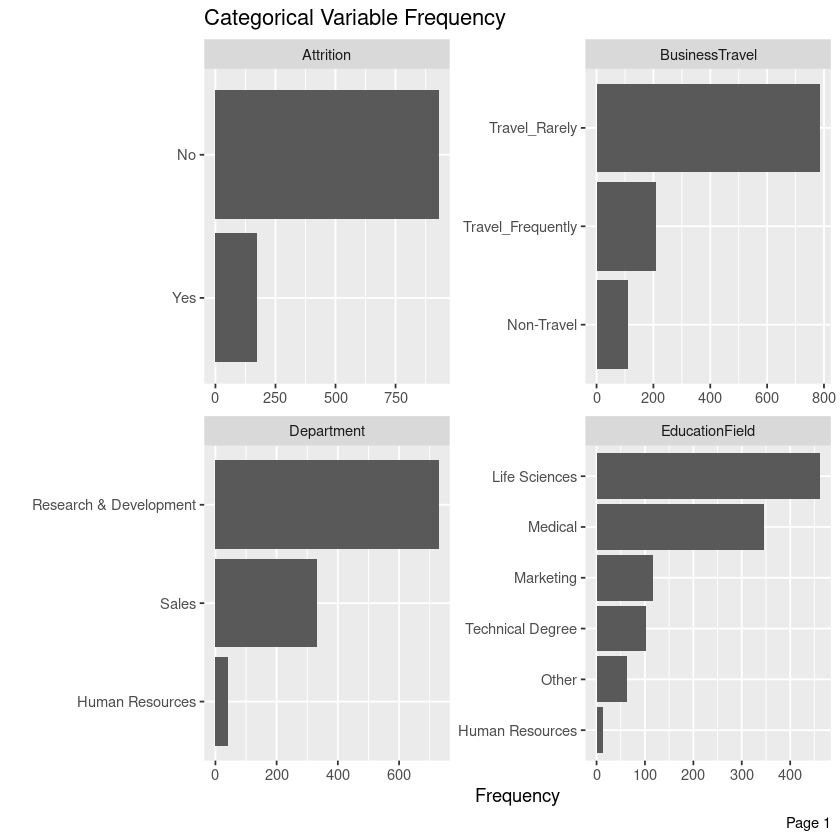

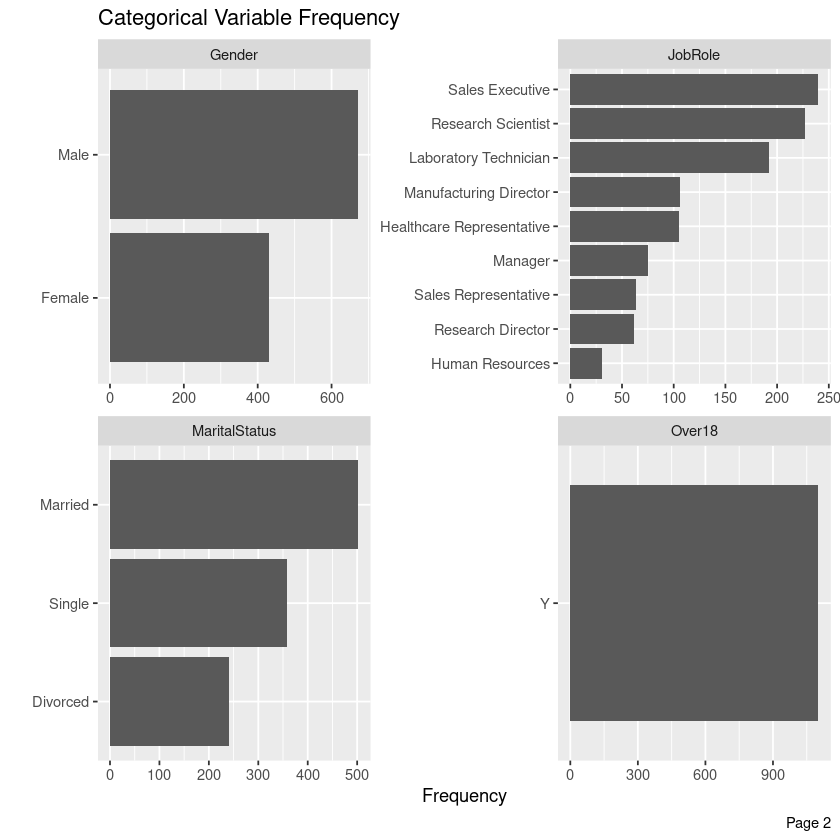

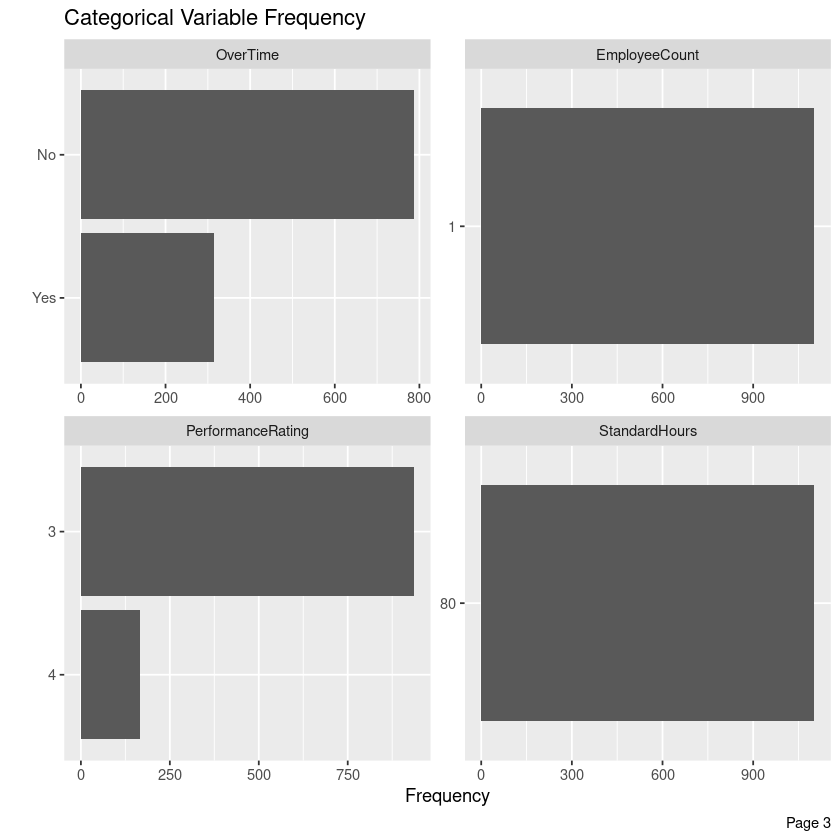

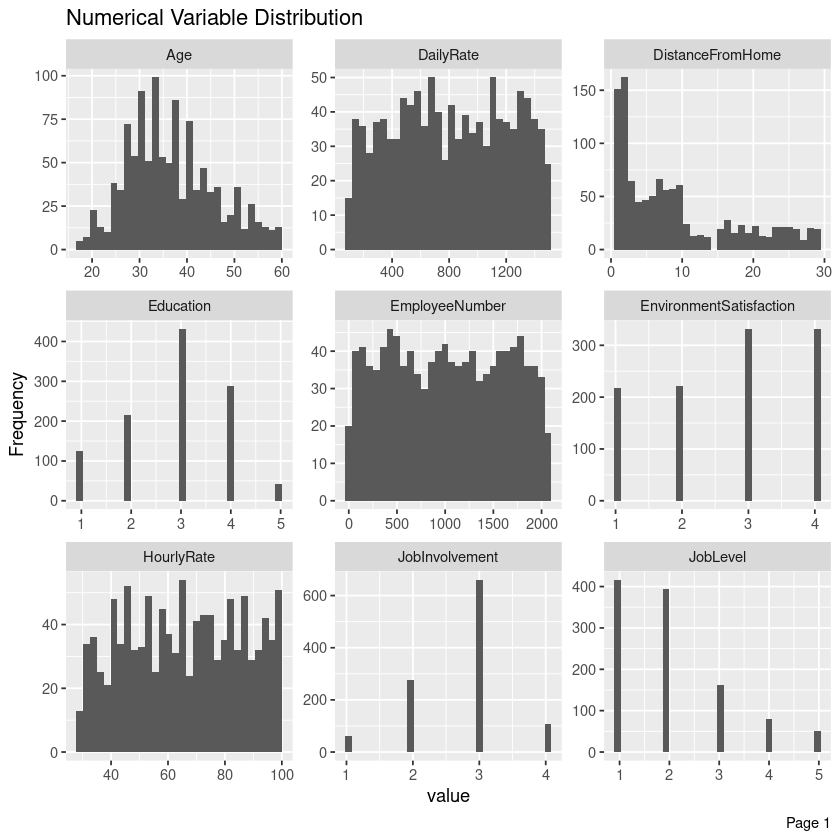

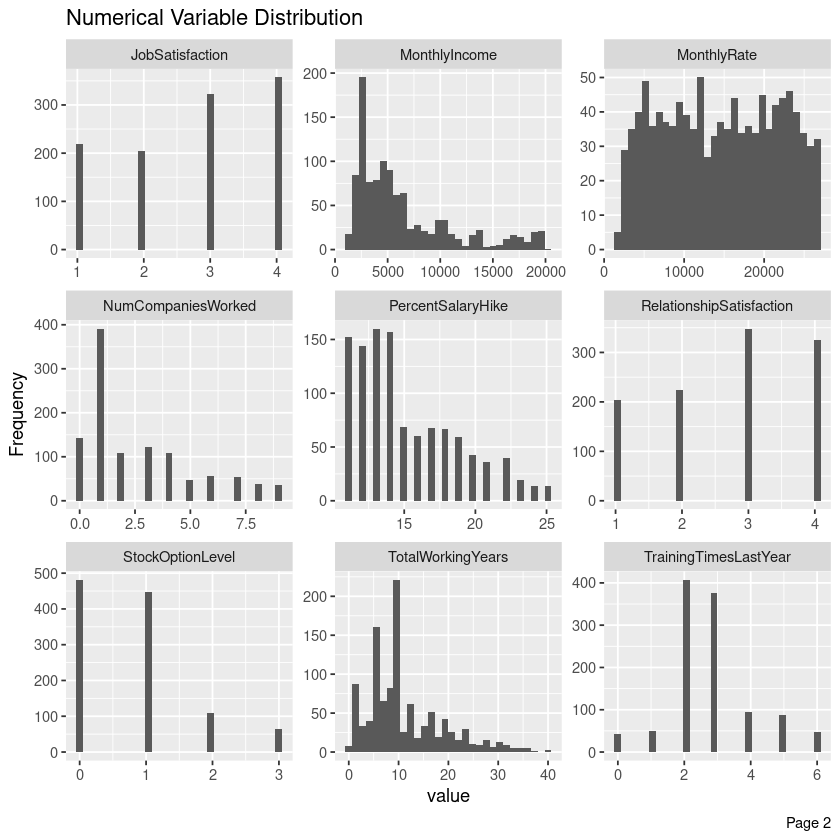

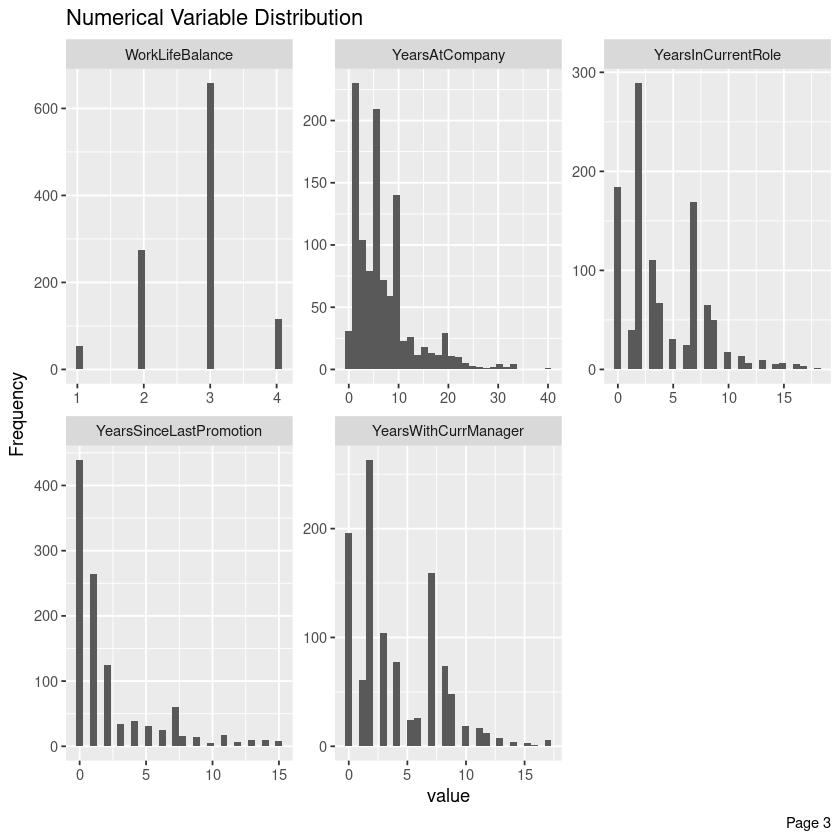

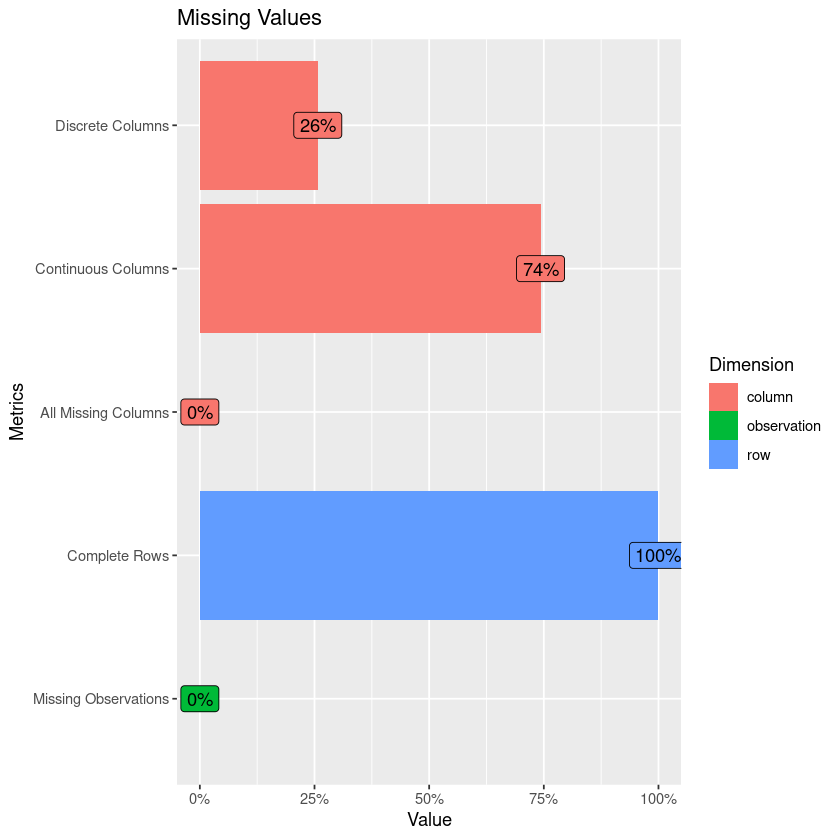

In [2]:
library(DataExplorer)
library(dplyr)
library(ggplot2)
library(reshape2)

# First few rows
head(hr)
# All columns' types and freq/dist (summary and plots)
str(hr)
summary(hr)
plot_bar(hr, title = "Categorical Variable Frequency", nrow = 2, ncol = 2)
plot_histogram(hr, title = "Numerical Variable Distribution", nrow = 3, ncol = 3)
# Info about missing values and outliers
plot_intro(hr, title = "Missing Values")

There are several noticable things from our exploratory output above:

1. `Attrition` and `YearsAtCompany` are our status and time variables of interest for survival analysis, while `EmployeeNumber` is the unique identification variable.

2. There are three single-valued variables (`EmployeeCount`, `Over18`, `StandardHours`) which cannot be considered for building a risk model. We will filter these variables via column name list.

3. All string variables are categorical, three of which (`Attrition`, `Over18`, `OverTime`) are semantically Boolean. For clarity, we can format their type as such.

4. All numerical features are integers, which for the purpose of modelling will be treated as continuous. This also includes rating/level variables such as `Education` and `JobInvolvement`.

5. There is no issues of missing values nor distinctive outliers. We will incorporate outlier removal on our model development later.


Some more nuanced observations:

1. The numerical variables seem to be distributed mostly like a right-skewed bell curve, with a few exceptions. The variables `DailyRate`, `MonthlyRate` and `HourlyRate` seem to be uniformly distributed which is very unusual. This might be accidentally introduced in our synthetic data creation. For this reason, we filter these columns from our consideration.

2. My separate exploration indicates some potential cross-column consistency issues on temporal columns (`Age`, `TotalWorkingYears`, `Years...`), such as whether a column should be larger/equal to another. But I was not able to verify this due to the lack of complete column descriptions. We are therefore skipping cleaning this aspect. I also make an assumption that the zero values in these columns (particularly `YearsAtCompany`) mean a round-down of "six months or less".

3. The `Attrition` rate is around $10-20\%$, which based on [some online information that I read](https://stats.stackexchange.com/questions/357466/are-unbalanced-datasets-problematic-and-how-does-oversampling-purport-to-he?noredirect=1&lq=1) is not enough to pragmatically justify data-imbalance resampling. Adjusting the weights in model's metrics or incorporating external knowledge about minority class into the model could be an alternative for future attempts.

We now perform the data formatting and column filtering:

In [3]:
cat_cols <- c("BusinessTravel", "Department", "Gender", "EducationField", "JobRole", "MaritalStatus")
bool_cols <- c("Attrition", "Over18", "OverTime")
char_to_bool <- function (col) { col %in% c("Yes", "Y", TRUE) }
is_single_col <- function (col) { length(unique(col)) == 1 }
invalid_unif_cols <- c("DailyRate", "MonthlyRate", "HourlyRate")

hr_prep <- hr %>%
  # Format data types
  mutate_at(cat_cols, factor) %>%
  mutate_at(bool_cols, char_to_bool) %>%
  # Filter irrelevant columns
  select(-where(is_single_col)) %>%
  select(-any_of(invalid_unif_cols))

head(hr_prep)

Age Attrition BusinessTravel    Department             DistanceFromHome
1 41   TRUE     Travel_Rarely     Sales                   1              
2 49  FALSE     Travel_Frequently Research & Development  8              
3 37   TRUE     Travel_Rarely     Research & Development  2              
4 33  FALSE     Travel_Frequently Research & Development  3              
5 32  FALSE     Travel_Frequently Research & Development  2              
6 36  FALSE     Travel_Rarely     Research & Development 27              
  Education EducationField EmployeeNumber EnvironmentSatisfaction Gender ⋯
1 2         Life Sciences   1             2                       Female ⋯
2 1         Life Sciences   2             3                       Male   ⋯
3 2         Other           4             4                       Male   ⋯
4 4         Life Sciences   5             4                       Female ⋯
5 2         Life Sciences   8             4                       Male   ⋯
6 3         Medical        13             3                       Male   ⋯
  PerformanceRating RelationshipSatisfaction StockOptionLevel TotalWorkingYears
1 3                 1                        0                 8               
2 4                 4                        1                10               
3 3                 2                        0                 7               
4 3                 3                        0                 8               
5 3                 3                        0                 8               
6 3                 2                        2                17               
  TrainingTimesLastYear WorkLifeBalance YearsAtCompany YearsInCurrentRole
1 0                     1                6             4                 
2 3                     3               10             7                 
3 3                     3                0             0                 
4 3                     3                8             7                 
5 2                     2                7             7                 
6 3                     2                7             7                 
  YearsSinceLastPromotion YearsWithCurrManager
1 0                       5                   
2 1                       7                   
3 0                       0                   
4 3                       0                   
5 3                       6                   
6 7                       7

From domain knowledge, we have time-dependent variables that are semantically coupled to `YearsAtCompanies`, such as `Age`, `TotalWorkingYears`, `YearsInCurrentRole`, `YearsWithCurrManager` and `YearsSinceLastPromotion`(a separate check on our data shows around $70\%$ correlation). This is not insightful for our models, so we exclude these columns and substitute them with `NotWorkingYears` and `YearsAtOtherCompanies`.

In [4]:
coupled_temporal_cols <- c("Age", "TotalWorkingYears", "YearsWithCurrManager", "YearsInCurrentRole", "YearsSinceLastPromotion")

hr_prep <- hr_prep %>%
  # Adding new temporal columns
  mutate(NotWorkingYears = Age - TotalWorkingYears) %>%
  mutate(YearsAtOtherCompanies = TotalWorkingYears - YearsAtCompany) %>%
  # Removing earlier temporal columns
  select(-any_of(coupled_temporal_cols))

head(hr_prep)

Attrition BusinessTravel    Department             DistanceFromHome Education
1  TRUE     Travel_Rarely     Sales                   1               2        
2 FALSE     Travel_Frequently Research & Development  8               1        
3  TRUE     Travel_Rarely     Research & Development  2               2        
4 FALSE     Travel_Frequently Research & Development  3               4        
5 FALSE     Travel_Frequently Research & Development  2               2        
6 FALSE     Travel_Rarely     Research & Development 27               3        
  EducationField EmployeeNumber EnvironmentSatisfaction Gender JobInvolvement ⋯
1 Life Sciences   1             2                       Female 3              ⋯
2 Life Sciences   2             3                       Male   2              ⋯
3 Other           4             4                       Male   2              ⋯
4 Life Sciences   5             4                       Female 3              ⋯
5 Life Sciences   8             4                       Male   3              ⋯
6 Medical        13             3                       Male   3              ⋯
  OverTime PercentSalaryHike PerformanceRating RelationshipSatisfaction
1  TRUE    11                3                 1                       
2 FALSE    23                4                 4                       
3  TRUE    15                3                 2                       
4  TRUE    11                3                 3                       
5 FALSE    13                3                 3                       
6 FALSE    13                3                 2                       
  StockOptionLevel TrainingTimesLastYear WorkLifeBalance YearsAtCompany
1 0                0                     1                6            
2 1                3                     3               10            
3 0                3                     3                0            
4 0                3                     3                8            
5 0                2                     2                7            
6 2                3                     2                7            
  NotWorkingYears YearsAtOtherCompanies
1 33               2                   
2 39               0                   
3 30               7                   
4 25               0                   
5 24               1                   
6 19              10

### Correlation Handling

Next, we also look at the column correlations. This is for two reasons: (1) High correlated variables introduce multicollinearity that breaks the assumption of CoxPH model and is redundant to the performance of RSF model, (2) There could be some interesting patterns suggesting new features or erroneous inputs.

For now, we will select the correlated pairs higher than $80\%$ for feature removal (we can improve this by performing PCA, perhaps for later time), while plotting the ones higher than $40\%$. We present several interesting comparisons based on looking at individual correlation graphs.

Var1                             Var2                        value     
1  JobLevel                         MonthlyIncome                0.9510894
2  DepartmentSales                  JobRoleSales Executive       0.8018498
3  PercentSalaryHike                PerformanceRating            0.7656281
4  JobRoleManager                   MonthlyIncome                0.6051062
5  JobLevel                         JobRoleManager               0.5407832
6  DepartmentSales                  EducationFieldMarketing      0.5212326
7  JobLevel                         YearsAtCompany               0.5090405
8  JobRoleResearch Director         MonthlyIncome                0.4974747
9  MonthlyIncome                    YearsAtOtherCompanies        0.4931469
10 MonthlyIncome                    YearsAtCompany               0.4869964
11 JobLevel                         YearsAtOtherCompanies        0.4795216
12 EducationFieldMarketing          JobRoleSales Executive       0.4566100
13 NumCompaniesWorked               YearsAtOtherCompanies        0.4285016
14 JobLevel                         JobRoleResearch Director     0.4226358
15 JobLevel                         JobRoleResearch Scientist   -0.4034731
16 DepartmentResearch & Development EducationFieldMarketing     -0.4795124
17 EducationFieldLife Sciences      EducationFieldMedical       -0.5725100
18 MaritalStatusMarried             MaritalStatusSingle         -0.6358125
19 MaritalStatusSingle              StockOptionLevel            -0.6384012
20 DepartmentResearch & Development JobRoleSales Executive      -0.7376687
21 BusinessTravelTravel_Frequently  BusinessTravelTravel_Rarely -0.7590460
22 DepartmentResearch & Development DepartmentSales             -0.9199586

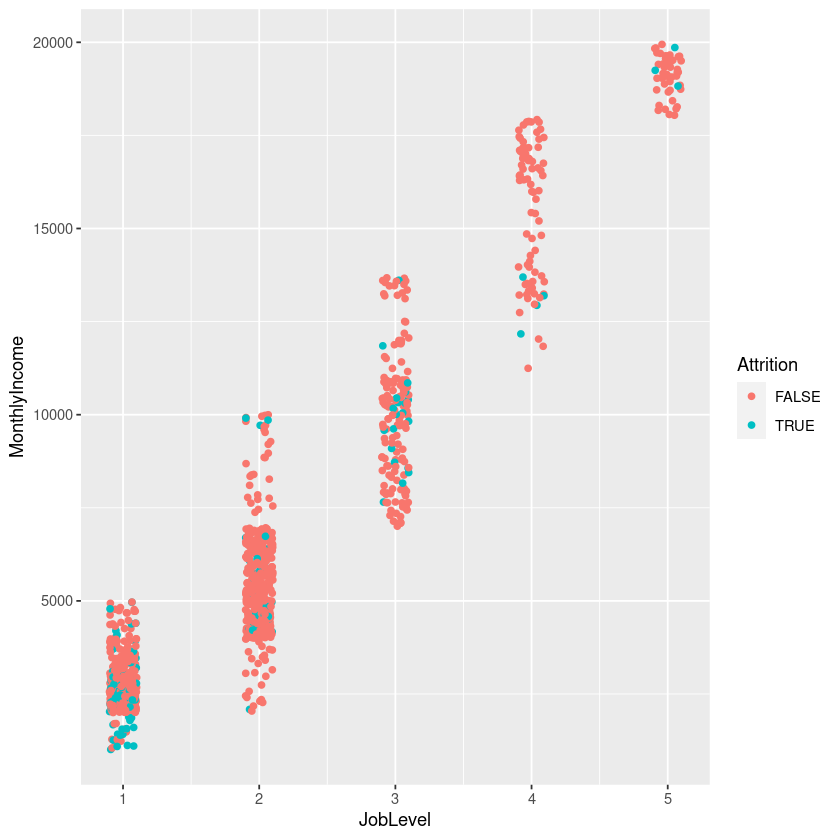

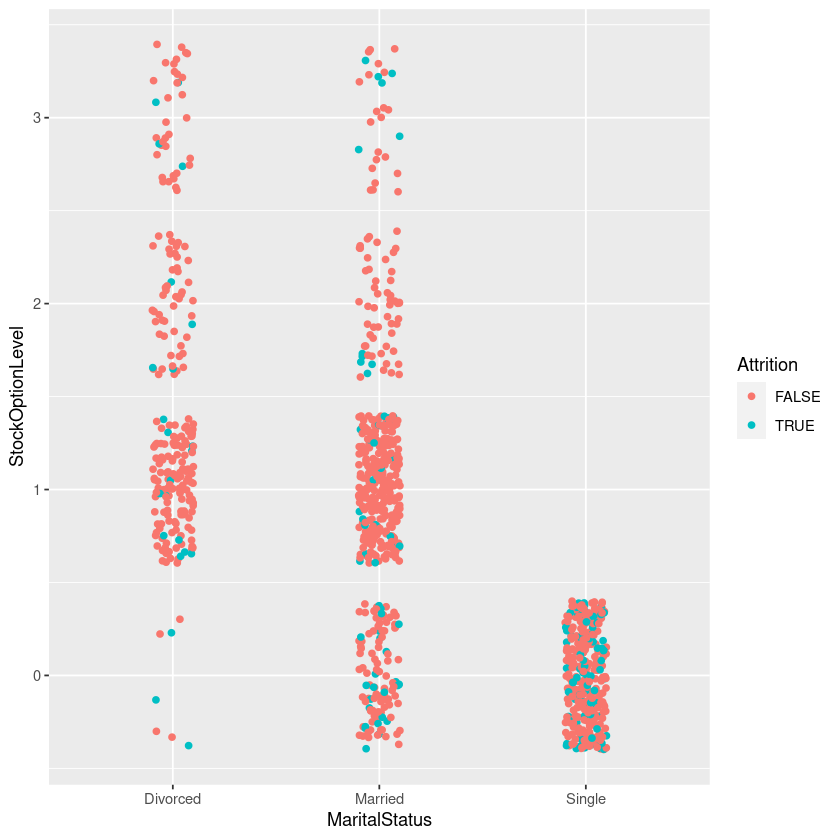

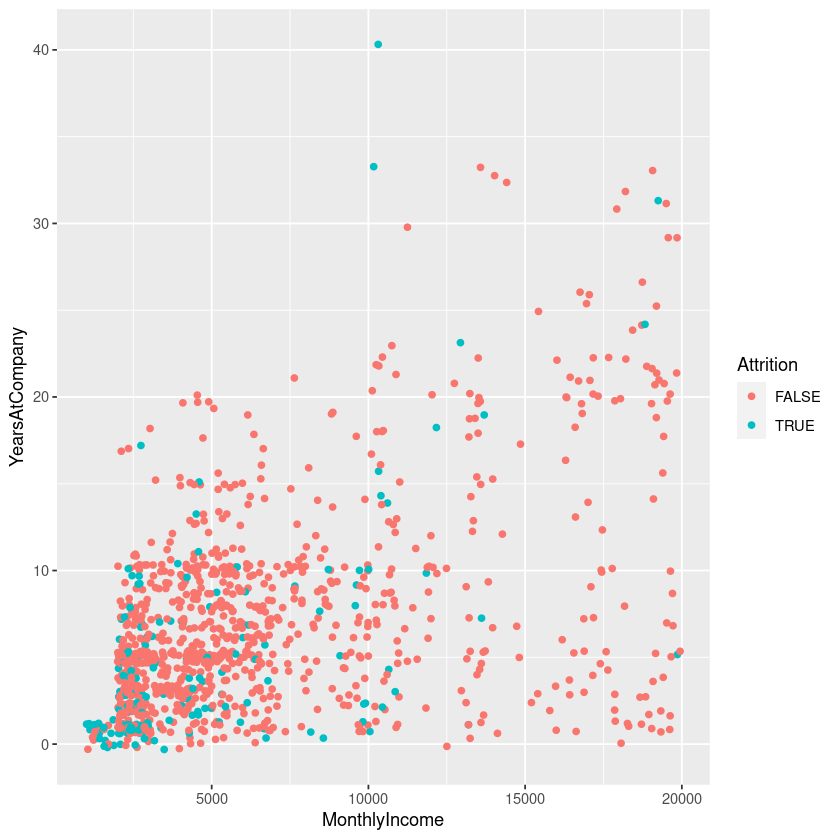

In [5]:
# Correlation functions: SOON

corr_table <- function (df, limit = 0){
  # Convert categories to dummies
  df2 <- model.matrix(~ 0+., df)

  # Dropping entries
  corr <- cor(df2)
  corr[lower.tri(corr, diag = TRUE)] <- NA
  corr[abs(corr) == 1] <- NA
  
  # Convert to long format, sorted
  res <- melt(corr)
  res <- na.omit(res)
  res <- res[abs(res$value) > limit,]
  res <- res[order(res$value, decreasing = TRUE),]
  rownames(res) <- 1:nrow(res)
  return(res)
}

corr_graphs <- function (df, limit = 0){
  # Scatter plots of correlated variables
  df2 <- model.matrix(~ 0+., df)
  ct <- corr_table(df, limit)
    
  for (i in 1:nrow(ct)) {
    col1 <- as.character(ct[i, "Var1"])
    col2 <- as.character(ct[i, "Var2"])
    p <- ggplot(as.data.frame(df2), aes(x = .data[[col1]], y = .data[[col2]], color = factor(AttritionTRUE))) +
          geom_point(position = position_jitter(width = .1))
    if (!is.numeric(df[[col1]])) {
        p <- p + geom_jitter(position = position_jitter(width = .1)) +
                stat_summary(fun.y = "mean", geom = "point", color = "red", size = 3)
    }
    print(p)
  }
}

#
corr_table(hr_prep, limit = 0.4)
#corr_graphs(hr_prep, limit = 0.4)
corr_vars <- list(x = c("JobLevel", "MaritalStatus", "MonthlyIncome"),
                  y = c ("MonthlyIncome", "StockOptionLevel", "YearsAtCompany"))
for (i in 1:3) {
  corr_x <- corr_vars$x[i]
  corr_y <- corr_vars$y[i]
  print(ggplot(hr_prep, aes(.data[[corr_x]], y = .data[[corr_y]], color = Attrition)) +
        geom_point(position = position_jitter(width = .1)))
}

The correlation between `MonthlyIncome` and `JobLevel` is so strong at above $90\%$, and there is a simple, non-coincidental explanation for this: higher job responsibilities should be rewarded higher. We exclude `JobLevel` and only include `MonthlyIncome` in our features.

The negative correlation between single marital status and stock option levels suggests that all single employees have zero-level stocks. This leads me to plot both variables, which also revelas that other marital status do not affect stock option level distribution that much.

I also notice that `MonthlyIncome` under ~\$2,000 have a starkly different range of `YearsAtCompany`, almost as if it is artificially cut by someone. It also happens to have a high level of attrition. One possible reason I can think of is because **these are employees on internship**, which have a very different work arrangement compared to full-fledged employees. We thus remove these rows from our training data.

In [6]:
high_corr_cols <- c("JobLevel")

hr_prep <- hr_prep %>%
  # Removing highly-correlated variables
  select(-any_of(high_corr_cols)) %>%
  # Removing interning rows
  filter(MonthlyIncome >= 2000)

dim(hr_prep)

[1] 1078   25

---

## Developing Survival Models

We utilise Cox Proportional Hazard and Random Survival Forest models, available from R's library `Survival` and `randomForestSRC`. These models offer distinct approaches: CoxPH model is commonly used in statistical analysis due to its interpretability and generalisation, allowing researchers to assess the contribution of variables and generate event's theoretical framework. Meanwhile, RSF is a powerful machine learning algorithm with embedded feature selection capabilities such as variable importance, which is able to incorporate non-linear relationships.

A [comparative research on high-dimensional data](https://www.nature.com/articles/s41598-020-77220-w) indicates that CoxPH with univariate concordance index's (C-index) feature selection and RSF with variable importance's feature selection perform quite well on empirical data. As a result, we are pairing both models with aforementioned feature selection methods.

We use concordance index (C-index) and Prediction Error Curve (PEC, i.e. integrated Brier score) to measure models' accuracy. The `YearsAtCompany` is set as survival time variable, and `Attrition` as status variable.

Below is the code for various functions used in our modelling:

In [37]:
library(survival)
suppressMessages(library(randomForestSRC))
library(SurvMetrics)
suppressMessages(library(pec))

# === Models

TIME <- "YearsAtCompany"
STATUS <- "Attrition"
ID <- "EmployeeNumber"

coxph_model <- function (df) {
  formula <- as.formula(paste("Surv(", TIME, ", ", STATUS, ") ~ ."))
  model <- coxph(data = df %>% select(-any_of(ID)), formula = formula, method = "efron", x = TRUE)
  return(model)
}

rsf_model <- function (df, params = NULL) {
  if (is.null(params)) {
    params <- list(ntree = 100, mtry = NULL)
  }
  formula <- as.formula(paste("Surv(", TIME, ", ", STATUS, ") ~ ."))
  model <- rfsrc(data = df %>% select(-any_of(ID)), formula = formula,
                 ntree = params$ntree, mtry = params$mtry)
  return(model)
}

model_f <- function (mode, params = NULL) { if (mode == "coxph") coxph_model
                                            else if (mode == "rsf") function(df) { rsf_model(df, params = params) }
                                            else NULL }

In [8]:
# === Feature selection

# 1. Cox score

coxph_score <- function (df, model) { # ignore the model
  features <- names(df)[!(names(df) %in% c(TIME, STATUS))]
  scores <- sapply(features, function (col){
    summary(coxph_model(df[c(TIME, STATUS, col)]))$concordance[1]
  })
  names(scores) <- features
  return(scores)
}

coxph_details <- function (model) {
  return(summary(model)$coefficients[, c("exp(coef)", "coef", "se(coef)")])
}

# 2. RSF Importance

rsf_importance <- function (df, model) {
  return(predict(model, data = df, importance = TRUE)$importance)
}

feature_rank_f <- function (mode) { if (mode == "coxph") coxph_score else if (mode == "rsf") rsf_importance else NULL }


# ===

print_feature_rank <- function (df, mode) {
  if (mode == "coxph") {
    print("Univariate Cox score:")
  } else {
    print("Variable importance:")
  }
  res <- feature_rank_f(mode)(df, model_f(mode)(df))
  print(res[order(res, decreasing = TRUE)])
}

In [9]:
# === Accuracy metrics

# SurvMetrics variables incompatible with custom functions:
#   model after df then tested after df2
survMetrics_wrapper <- function (df, df2, mode, metric_f) {
  tmp <- list(time = TIME, status = STATUS)
  TIME <<- "time"
  STATUS <<- "status"
  rename_survmetrics <- function (df) {
    names(df)[names(df) == tmp$time] <- TIME
    names(df)[names(df) == tmp$status] <- STATUS
    return(df)
  }
  res <- metric_f(model_f(mode)(rename_survmetrics(df)), rename_survmetrics(df2), t_star = -1)
  TIME <<- tmp$time
  STATUS <<- tmp$status
  return(res)
}

# 1. Concordance index

c_index <- function (df, df2, mode) {
  return(survMetrics_wrapper(df, df2, mode, SurvMetrics::Cindex))
}

# 2. Brier score: SOON

brier_score <- function (df, df2, mode) {
  return(survMetrics_wrapper(df, df2, mode, SurvMetrics::Brier))
}

# Legacy code from pec:
plot_pec <- function (df, model) { # split???
  formula <- as.formula(paste("Surv(", TIME, ", ", STATUS, ") ~ ."))
  pred_error <- pec(model, data = df, splitmethod = "cv10", formula = formula, cens.model = "marginal", reference = FALSE)
  plot(pred_error, xlim = c(0, 10), ylim = c(0, 0.25)) # 0.25 is the worst case scenario (random model)
  title("Prediction Error Curve")
}

# ===

print_c_index <- function (df, df2, mode) {
  print("Concordance index:")
  print(c_index(df, df2, mode))
}

In [10]:
# === Cross-validation

cross_val <- function (df, mode, feature_num = 1, params = NULL, k = 5) {
  random_index <- sample(1:nrow(df))
  performance_score1_vec <- numeric(k)
  for (fold in 1:k) {
    prev_end <- round((fold-1)/k * nrow(df))
    size <- round(fold * nrow(df)/k) - round((fold-1) * nrow(df)/k)
    idx <- random_index[(prev_end+1):(prev_end+size)]
    test <- df[idx, ]
    train <- df[-idx, ]
    
    # Preprocessing
    tt <- prepare(train, test, mode)
    train <- tt[[1]]
    test <- tt[[2]]
    
    # Initial model
    model1 <- model_f(mode, params)(train)
    feature_rank1 <- feature_rank_f(mode)(test, model1)
    feature_rank1 <- feature_rank1[order(feature_rank1, decreasing = TRUE)]

    # Correlated columns removal
    feature_redundancy <- corr_table(train, limit = 0.8)
    for (i in 1:nrow(feature_redundancy)) {
      # Retain higher rank, if any
      x <- feature_redundancy[i, "Var1"]
      y <- feature_redundancy[i, "Var2"]
      if (x %in% feature_rank1 && y %in% feature_rank1) {
        x_rank <- which(feature_rank1 == x)
        y_rank <- which(feature_rank1 == y)
        feature_rank1 <- feature_rank1[-max(x_rank, y_rank)]
      }
    }
    
    # Next model
    feature_rank2 <- names(feature_rank1)[1:min(feature_num, length(names(feature_rank1)))]
    #print("Choosing features ...")
    #print(feature_rank2)
    train2 <- train[c(TIME, STATUS, feature_rank2)]
    test2 <- test[c(TIME, STATUS, feature_rank2)]
    performance_score1 <- c_index(train2, test2, mode)
    # Brier score soon
    
    performance_score1_vec[fold] <- performance_score1
  }

  # !!! Return metrics, boxplot outside: soon
  print(paste0("Performance score via concordance index, for feature number = ", feature_num, ":"))
  print(paste0("Mean: ", mean(performance_score1_vec)))
  print(performance_score1_vec)
  print(paste0("SE: ", sd(performance_score1_vec)))
}

In [11]:
# === Preprocessing: very dataset-specific so no need for TIME/STATUS/ID here

prepare <- function (df, df2, mode = "") {
  df <- prepare_gen(df)
  df2 <- prepare_gen(df2)

  # Train set additional process: intern and outlier removal
  df <- df %>%
    mutate(IsIntern = (MonthlyIncome < 2000)) %>%
    mutate(iqr = IQR(YearsAtCompany), 
            q1 = quantile(YearsAtCompany, probs = c(0.25)) - 3*iqr,
            q3 = quantile(YearsAtCompany, probs = c(0.75)) + 3*iqr,
            IsOutlier = between(YearsAtCompany, q1, q3)) %>%
    select(-c(iqr, q1, q3))
  df_train <- df %>% filter(!(IsIntern & IsOutlier)) %>% select(-c(IsIntern, IsOutlier))
  df_removed <- df %>% filter(IsIntern & IsOutlier) %>% select(-c(IsIntern, IsOutlier))

  # Assumption check for CoxPH model
  if (mode == "coxph") {
    ph_obj <- df_train %>%
      select(-c(Department, JobRole)) %>%
      coxph_model %>% proportional_hazard_table
    non_ph_cols <- names(which(ph_obj$table[, "p"] < 0.01))
    non_ph_cols <- non_ph_cols[!(non_ph_cols == "GLOBAL")]
    for (col in non_ph_cols) { # There should be a better Tidyverse syntax
      #inter_col <- paste0("Inter_TIME_", col)
      #df_train[inter_col] <- df_train[TIME] * df_train[col]
      #df2[inter_col] <- df2[TIME] * df2[col]
      #df_removed[inter_col] <- df_removed[TIME] * df_removed[col]
    }
  }

  return(list(df_train, df2, df_removed))
}

prepare_gen <- function (df) {
  df %>%
    mutate_at(cat_cols, factor) %>%
    mutate_at(bool_cols, char_to_bool) %>%
    select(-where(is_single_col)) %>%
    select(-any_of(invalid_unif_cols)) %>%
    mutate(NotWorkingYears = Age - TotalWorkingYears) %>%
    mutate(YearsAtOtherCompanies = TotalWorkingYears - YearsAtCompany) %>%
    select(-any_of(coupled_temporal_cols)) %>%
    select(-any_of(high_corr_cols))
}

proportional_hazard_table <- function (model) {
  return(cox.zph(model))
}

### Preprocessing Validation Data

First, we will do the same initial preprocessing onto our validation data:

In [12]:
hr_valid <- prepare_gen(hr_valid)

### Outlier Removal

We remove outlier data with respect to survival time variable `YearsAtCompany`, to prevent too much variability in our training data. For model simplicity, we will remove extreme points farther than three times the interquartile difference.

In [13]:
hr_train <- hr_prep %>%
    mutate(iqr = IQR(YearsAtCompany),
            q3 = quantile(YearsAtCompany, probs = c(0.75)) + 3*iqr,  
            q1 = quantile(YearsAtCompany, probs = c(0.25)) - 3*iqr) %>%
    filter(between(YearsAtCompany, q1, q3)) %>%
    select(-c(iqr, q1, q3))

dim(hr_train)

[1] 1065   25

## Cox Proportional Hazard: Feature Selection

There is another assumption of proportional hazard for CoxPH, which can be checked by performing statistical test on Schoenfeld residuals. The error message from `check_proportional_hazard()` suggests that `Department` and `JobRole` should be taken out from the test due to large fitted coefficients, although we will still include in the feature selection. The result does not seem to indicate any signficant violation (all $p > 0.01$)

In [14]:
# Check assumption
hr_train %>%
  select(-c(Department, JobRole)) %>%
  coxph_model %>% proportional_hazard_table

                            chisq df     p
BusinessTravel           6.38e-02  2 0.969
DistanceFromHome         2.01e-01  1 0.654
Education                8.07e-02  1 0.776
EducationField           5.66e+00  5 0.340
EnvironmentSatisfaction  5.44e-02  1 0.816
Gender                   1.06e+00  1 0.304
JobInvolvement           4.88e-02  1 0.825
JobSatisfaction          3.15e+00  1 0.076
MaritalStatus            1.43e+00  2 0.490
MonthlyIncome            1.91e+00  1 0.167
NumCompaniesWorked       2.78e+00  1 0.095
OverTime                 1.33e-04  1 0.991
PercentSalaryHike        8.82e-01  1 0.348
PerformanceRating        5.14e-01  1 0.474
RelationshipSatisfaction 9.50e-01  1 0.330
StockOptionLevel         8.03e-02  1 0.777
TrainingTimesLastYear    2.98e-03  1 0.956
WorkLifeBalance          1.25e-02  1 0.911
NotWorkingYears          4.15e+00  1 0.042
YearsAtOtherCompanies    1.46e-01  1 0.702
GLOBAL                   2.78e+01 26 0.367

Now we try our first iteration below. The concordance index of the initial model on validation set with all (feasible) columns selected is around $85\%$, with the PEC graph showing that our model has averagely around $7\%$ error in describing employee attrition within the span of 10 years.

[1] "Univariate Cox score:"
                 JobRole            MonthlyIncome                 OverTime 
               0.7145897                0.7142312                0.6606194 
        StockOptionLevel  EnvironmentSatisfaction            MaritalStatus 
               0.6135896                0.5915960                0.5910445 
         JobSatisfaction           JobInvolvement       NumCompaniesWorked 
               0.5858966                0.5754261                0.5628367 
          BusinessTravel               Department         DistanceFromHome 
               0.5574038                0.5519433                0.5489235 
   TrainingTimesLastYear           EducationField RelationshipSatisfaction 
               0.5485742                0.5452097                0.5328547 
               Education          NotWorkingYears          WorkLifeBalance 
               0.5261716                0.5259786                0.5202101 
       PercentSalaryHike                   Gender        Per

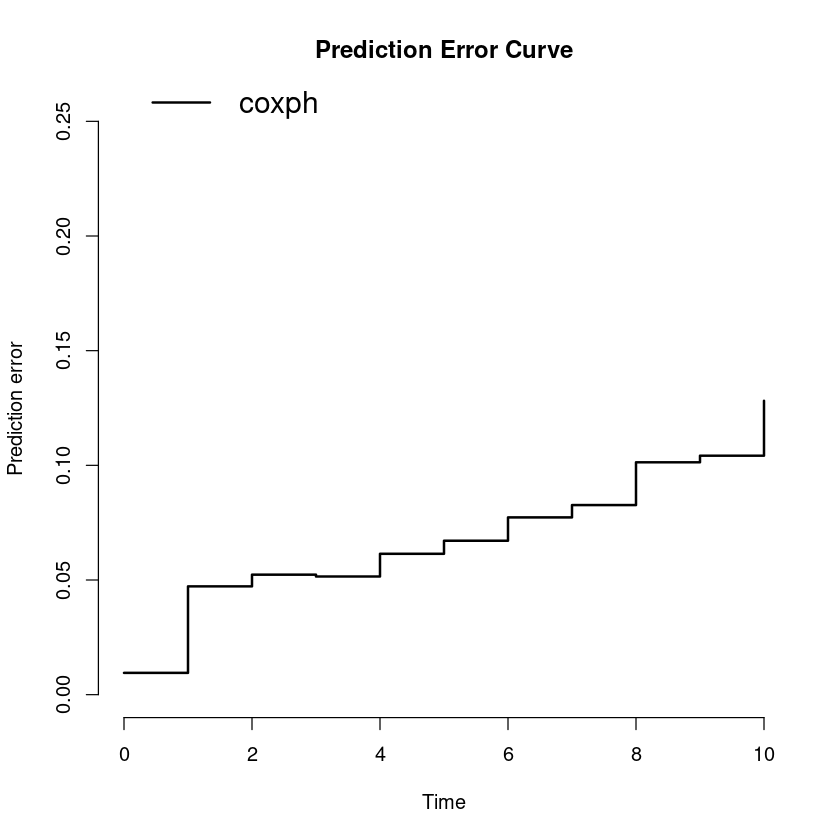

In [15]:
# First iteration
options(warn = -1) # Suppress warnings due to big coxph coefficients

print_feature_rank(hr_train, "coxph")
print_c_index(hr_train, hr_valid, "coxph")
plot_pec(hr_valid, coxph_model(hr_train))

options(warn = 0) # Reactivate warnings

We can see that (under this particular seed) `JobRole` and `MonthlyIncome` have much higher univariate concordance index compared to others. We now perform cross-validation with fold `k = 5` to find the best regression model.

**The tuning of the number of features in CoxPH seems to suggest that picking top-3 or 4 variables will hit the balance between simplicity and accuracy, with c-index $\approx$ 82\%.**

In [16]:
options(warn = -1) 

for (feature_num in 1:8) {
  cross_val(hr_full, "coxph", feature_num) 
}

options(warn = 0)

[1] "Performance score via concordance index, for feature number = 1:"
[1] "Mean: 0.7643794"
[1] 0.724303 0.739016 0.808415 0.786991 0.763172
[1] "SE: 0.0342829995522562"
[1] "Performance score via concordance index, for feature number = 2:"
[1] "Mean: 0.777446"
[1] 0.754129 0.810871 0.802884 0.743785 0.775561
[1] "SE: 0.0293454472789222"
[1] "Performance score via concordance index, for feature number = 3:"
[1] "Mean: 0.8173216"
[1] 0.825593 0.813948 0.812011 0.822781 0.812275
[1] "SE: 0.00638891475917468"
[1] "Performance score via concordance index, for feature number = 4:"
[1] "Mean: 0.8247598"
[1] 0.809686 0.849696 0.772379 0.830181 0.861857
[1] "SE: 0.0353495876312581"
[1] "Performance score via concordance index, for feature number = 5:"
[1] "Mean: 0.8256364"
[1] 0.821929 0.780997 0.855474 0.842906 0.826876
[1] "SE: 0.0282687058122582"
[1] "Performance score via concordance index, for feature number = 6:"
[1] "Mean: 0.8279208"
[1] 0.766518 0.780424 0.885182 0.848954 0.858526
[1]

## Random Survival Forest: Feature Selection

We develop Random Survival Forest model for our data now. The number of trees used in RSF is `ntree = 100` which is on the lower scale than the default 500, but allows us to perform faster modelling. Instead we will tune the hyperparameter of the maximum number of features to split a tree `mtry`. By default, this is the square-root of the feature number, but it is possible that there is a slightly more optimised one nearby.

Note that there is no proportional hazard assumption here, so the initial feature set can be incorporated here.

The concordance index if all features are used is at around $85\%$, with PEC error under $7\%$ across ten years.

[1] "Variable importance:"
           MonthlyIncome                 OverTime                  JobRole 
            1.906794e-01             1.698847e-01             4.909049e-02 
 EnvironmentSatisfaction         StockOptionLevel          NotWorkingYears 
            3.701435e-02             3.419802e-02             3.207708e-02 
      NumCompaniesWorked          WorkLifeBalance            MaritalStatus 
            2.316957e-02             2.043888e-02             1.824954e-02 
          JobInvolvement    YearsAtOtherCompanies         DistanceFromHome 
            1.525860e-02             1.204425e-02             1.150677e-02 
   TrainingTimesLastYear          JobSatisfaction               Department 
            1.070015e-02             9.623367e-03             8.923846e-03 
          EducationField                Education        PercentSalaryHike 
            8.422158e-03             5.915664e-03             5.405857e-03 
          BusinessTravel RelationshipSatisfaction            

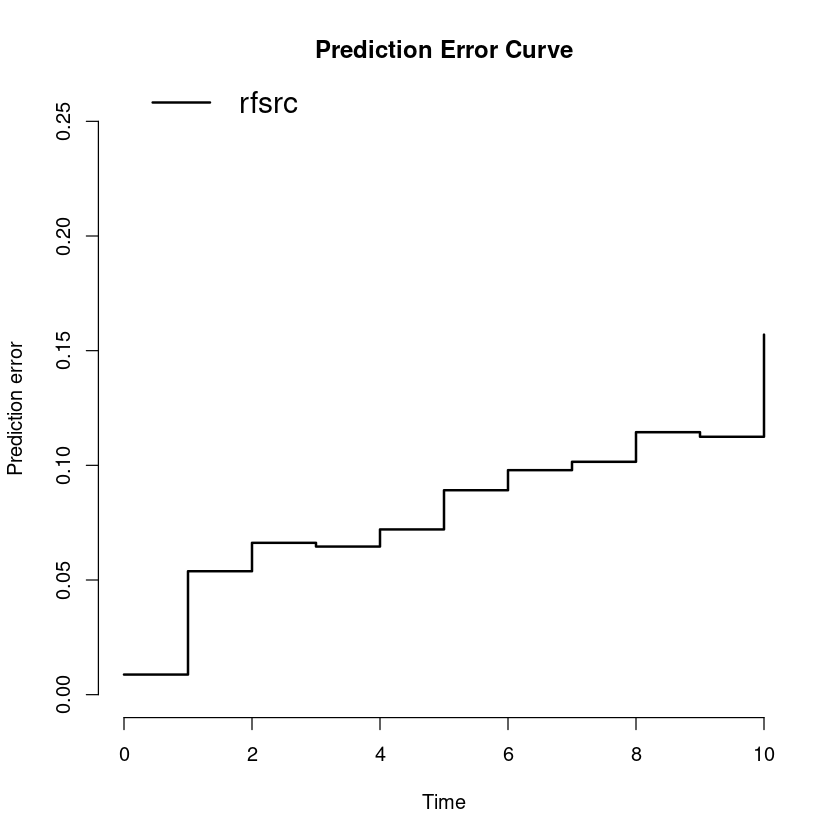

In [17]:
# First iteration
print_feature_rank(hr_train, "rsf")
print_c_index(hr_train, hr_valid, "rsf")
plot_pec(hr_valid, rsf_model(hr_train))

The prominently important features in RSF are `MonthlyIncome` and `OverTime`. Other features such as `EnvironmentSatisfaction` and `StockOptionLevel` also appear influential. The variable `JobRole` have several levels (i.e. 6), which might bias the RSF algorithm in favor of it.

**Our cross validation result below suggests that top-9 features (with default mtry) in RSF might be a good spot with c-index $\approx$ 84\%**.

In [39]:
for (feature_num in 5:16) {
  m <- round(sqrt(feature_num))
  for (i in list(-1, 0, 1)) {
    cross_val(hr_full, "rsf", feature_num, params = list(ntree = 100, mtry = m + i))
  }
}

[1] "Performance score via concordance index, for feature number = 5:"
[1] "Mean: 0.8026208"
[1] 0.785416 0.802269 0.823510 0.813393 0.788516
[1] "SE: 0.0161823457724769"
[1] "Performance score via concordance index, for feature number = 5:"
[1] "Mean: 0.8123324"
[1] 0.839061 0.788182 0.800055 0.788817 0.845547
[1] "SE: 0.027859370592316"
[1] "Performance score via concordance index, for feature number = 5:"
[1] "Mean: 0.799033"
[1] 0.829105 0.756406 0.769496 0.814865 0.825293
[1] "SE: 0.0336677163838001"
[1] "Performance score via concordance index, for feature number = 6:"
[1] "Mean: 0.7995336"
[1] 0.808349 0.788867 0.776613 0.828001 0.795838
[1] "SE: 0.0196270977171868"
[1] "Performance score via concordance index, for feature number = 6:"
[1] "Mean: 0.7861924"
[1] 0.727173 0.793332 0.879775 0.769622 0.761060
[1] "SE: 0.0574416707913341"
[1] "Performance score via concordance index, for feature number = 6:"
[1] "Mean: 0.812257"
[1] 0.769852 0.834654 0.824471 0.824205 0.808103
[1] "S

## Completing Final Models

Our final model is formed by two methods of CoxPH and RSF, each with optimal features of three and nine respectively. The features are manually picked based on our initial training data's feature ranking.

In [40]:
options(warn = -1) 

coxph_feature_num <- 3
rsf_feature_num <- 9
coxph_cols <- c("Attrition", "YearsAtCompany", "EmployeeNumber", "MonthlyIncome", "JobRole", "OverTime")
rsf_cols <- c("Attrition", "YearsAtCompany", "EmployeeNumber", "OverTime", "MonthlyIncome", "StockOptionLevel", "TrainingTimesLastYear",
              "EnvironmentSatisfaction", "JobRole", "NumCompaniesWorked", "NotWorkingYears", "WorkLifeBalance")

# Preparing the training data
TT_c <- prepare(hr_full, TEST, mode = "coxph")
TT_r <- prepare(hr_full, TEST, mode = "rsf")
TRAIN_c <- TT_c[[1]][coxph_cols]
TRAIN_r <- TT_r[[1]][rsf_cols]
coxph_final_model <- coxph_model(TRAIN_c)
rsf_final_model <- rsf_model(TRAIN_r)

options(warn = 0)

## Interlude: Feature Category Impact

Since `JobRole` appears influential in both CoxPH and RSF models, it is worth checking out which categories have large impact. An easy way to check this is via the full CoxPH summary table, provided in `coxph_details()`. It seems being Sales Reps in particular increases the hazard ratio by a whopping $8$ times, while Managers and Directors have a decreased hazard ratio.

In [41]:
coxph_details(coxph_final_model)

exp(coef) coef          se(coef)    
MonthlyIncome                 0.9998541 -0.0001459199 4.207791e-05
JobRoleHuman Resources        4.1438627  1.4216283636 5.347019e-01
JobRoleLaboratory Technician  4.6742325  1.5420649883 4.473337e-01
JobRoleManager                1.0379507  0.0372482972 7.251972e-01
JobRoleManufacturing Director 1.5473674  0.4365550551 5.083380e-01
JobRoleResearch Director      0.8991673 -0.1062861258 8.651232e-01
JobRoleResearch Scientist     2.7852139  1.0243246625 4.563654e-01
JobRoleSales Executive        3.6150988  1.2851191739 4.148708e-01
JobRoleSales Representative   8.7127392  2.1647862301 4.832741e-01
OverTimeTRUE                  3.5486498  1.2665671949 1.453463e-01

---

## Quantifying Employee Attrition Risk

We produce the estimated cumulative hazard function (CHF) of attrition for each employee for Random Survival Forest model, and hazard ratio relative to the exponent of mean for Cox Proportional Hazard model. In particular, the rank for employee risk based on RSF is determined by the long-term CHF for the next five years, since it is commonly the period where companies may conduct review of their structural performance.

In [49]:
# Saving the prediction data
years = 5
DATA_c <- rbind(TT_c[[1]], TT_c[[2]], TT_c[[3]])[coxph_cols]
DATA_c["HazardCox"] <- predict(coxph_final_model, DATA_c, type = "risk")
DATA_r <- rbind(TT_r[[1]], TT_r[[2]], TT_r[[3]])[rsf_cols]
rsf_pred_cols <- sapply(0:years, function (x) { paste0("HazardRSF", x) })
DATA_r[, rsf_pred_cols] <- predict(rsf_final_model, DATA_r)$chf[, 1 + (0:years)]

DATA_PRED <- inner_join(DATA_c %>% select(EmployeeNumber, HazardCox),
                        DATA_r %>% select(EmployeeNumber, all_of(rsf_pred_cols)),
                        by = "EmployeeNumber")
write.csv(DATA_PRED, "hr_hazard_data.csv", row.names=FALSE)

head(DATA_PRED)

EmployeeNumber HazardCox HazardRSF0  HazardRSF1  HazardRSF2  HazardRSF3 
1  1             14.050419 0.021754541 0.119198399 0.251355273 0.315471179
2  2              3.459830 0.000000000 0.004700488 0.004700488 0.004700488
3  4             32.108587 0.088995381 0.292885642 0.434597337 0.610620732
4  5             16.977259 0.026181691 0.164302838 0.219649616 0.270046963
5  8              7.844767 0.004742333 0.039116765 0.047006284 0.066227624
6 13              1.222969 0.001751323 0.008996695 0.023899454 0.023899454
  HazardRSF4  HazardRSF5 
1 0.342787417 0.510667874
2 0.006598247 0.008820469
3 0.755739155 0.994405313
4 0.350673669 0.502478465
5 0.079551119 0.090137319
6 0.038848911 0.059980516

## Visualising with Tableau

We also embed Tableau dashboard from our predicted risk level dataset, resulting in the visualiation of top-risk employees (each page holds 20 people), where user can group employees according to several factors describing trends of attrition risks.

(A legacy Plotly visualisation is also available in Github repository, under folder `employee-attrition/script.R`).

In [48]:
IRdisplay::display_html("<div class='tableauPlaceholder' id='viz1707660132144' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;IB&#47;IBMEmployeeAttritionRiskAssessmentVisualisation&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='IBMEmployeeAttritionRiskAssessmentVisualisation&#47;Dashboard1' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;IB&#47;IBMEmployeeAttritionRiskAssessmentVisualisation&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1707660132144');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.minHeight='750px';vizElement.style.maxHeight=(divElement.offsetWidth*1.77)+'px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>")

---

## Recommended Strategies

### Stay Interviews with High-Risk Employees

Conduct stay interviews with employees to understand their perspectives and needs. Use risk scores to prioritize who to interview, but recognize the limitations of only using a few variables to predict individuals and gain individual perspectives and concerns.

### Career Welfare Support

Survey employees on factors like overtime expectations, work-life balance satisfaction, company culture/environment to gain a holistic understanding beyond data variables. Overtime in particular seems correlated and needs some proper management.

### Targetted Retention Program for Sales Reps

Develop retention programs tailored specifically for sales representations, who showed higher attrition risk compared to other positions. Programs may include pilot mentorship, expanded training, career path guidance or revised compensation incentives. Further examining team satisfaction could provide additional insights. Assess needs periodically and refine programs over time as the influences on representative turnover are better understood.

### Financial Benefits & Compensation

Ensure that compensation and benefits packages are competitive and aligned with industry standards. Consider revising the stock option plans or other incentives to increase employee motivation and loyalty.

---

## Epilogue: Accuracy Check on Data

In [45]:
options(warn = -1)

c_index(TEST_c, TRAIN_c, "coxph")
c_index(TEST_r, TRAIN_r, "rsf")

options(warn = 0)

C index 
0.779133

C index 
0.760653

In [50]:
# Further improvement:
# - IBS/t_star from SurvMetrics, fix inter-vars via formula, better pipelining: recipes